Adapted from:

[1] M. G. Berman et al., ‘The Perception of Naturalness Correlates with Low-Level Visual Features of Environmental Scenes’, PLOS ONE, vol. 9, no. 12, p. e114572, Dec. 2014, doi: 10.1371/journal.pone.0114572.

In [17]:
import os
import json

import cv2
import numpy as np
from skimage import color, feature, filters, measure
import matplotlib.pyplot as plt

from utils import *

In [18]:
folder_path = "../data/in/Most_extreme_pictures"

def compute_W(hsv_img, r1=0.1, r2=0.85):
    """
    Compute W_H(S,I) for all pixels in an HSV image.

    Parameters:
        hsv_img   : np.ndarray, shape (H, W, 3), dtype uint8
                    OpenCV HSV image (H in 0–179, S in 0–255, V in 0–255).
        r1, r2    : float, exponents from the formula.

    Returns:
        W         : np.ndarray, shape (H, W), float32
                    W_H values per pixel (raw, no thresholding or normalization).
    """
    S = hsv_img[..., 1]
    I = hsv_img[..., 2]

    W = np.zeros_like(I)

    mask = (I != 0)
    W[mask] = S[mask] ** (r1 * (((255.0/255.0) / I[mask]) ** r2))

    return W

# Decision for W threshold and green hue range

Analyzing image: ../data/in/Most_extreme_pictures/HTHB02.jpg


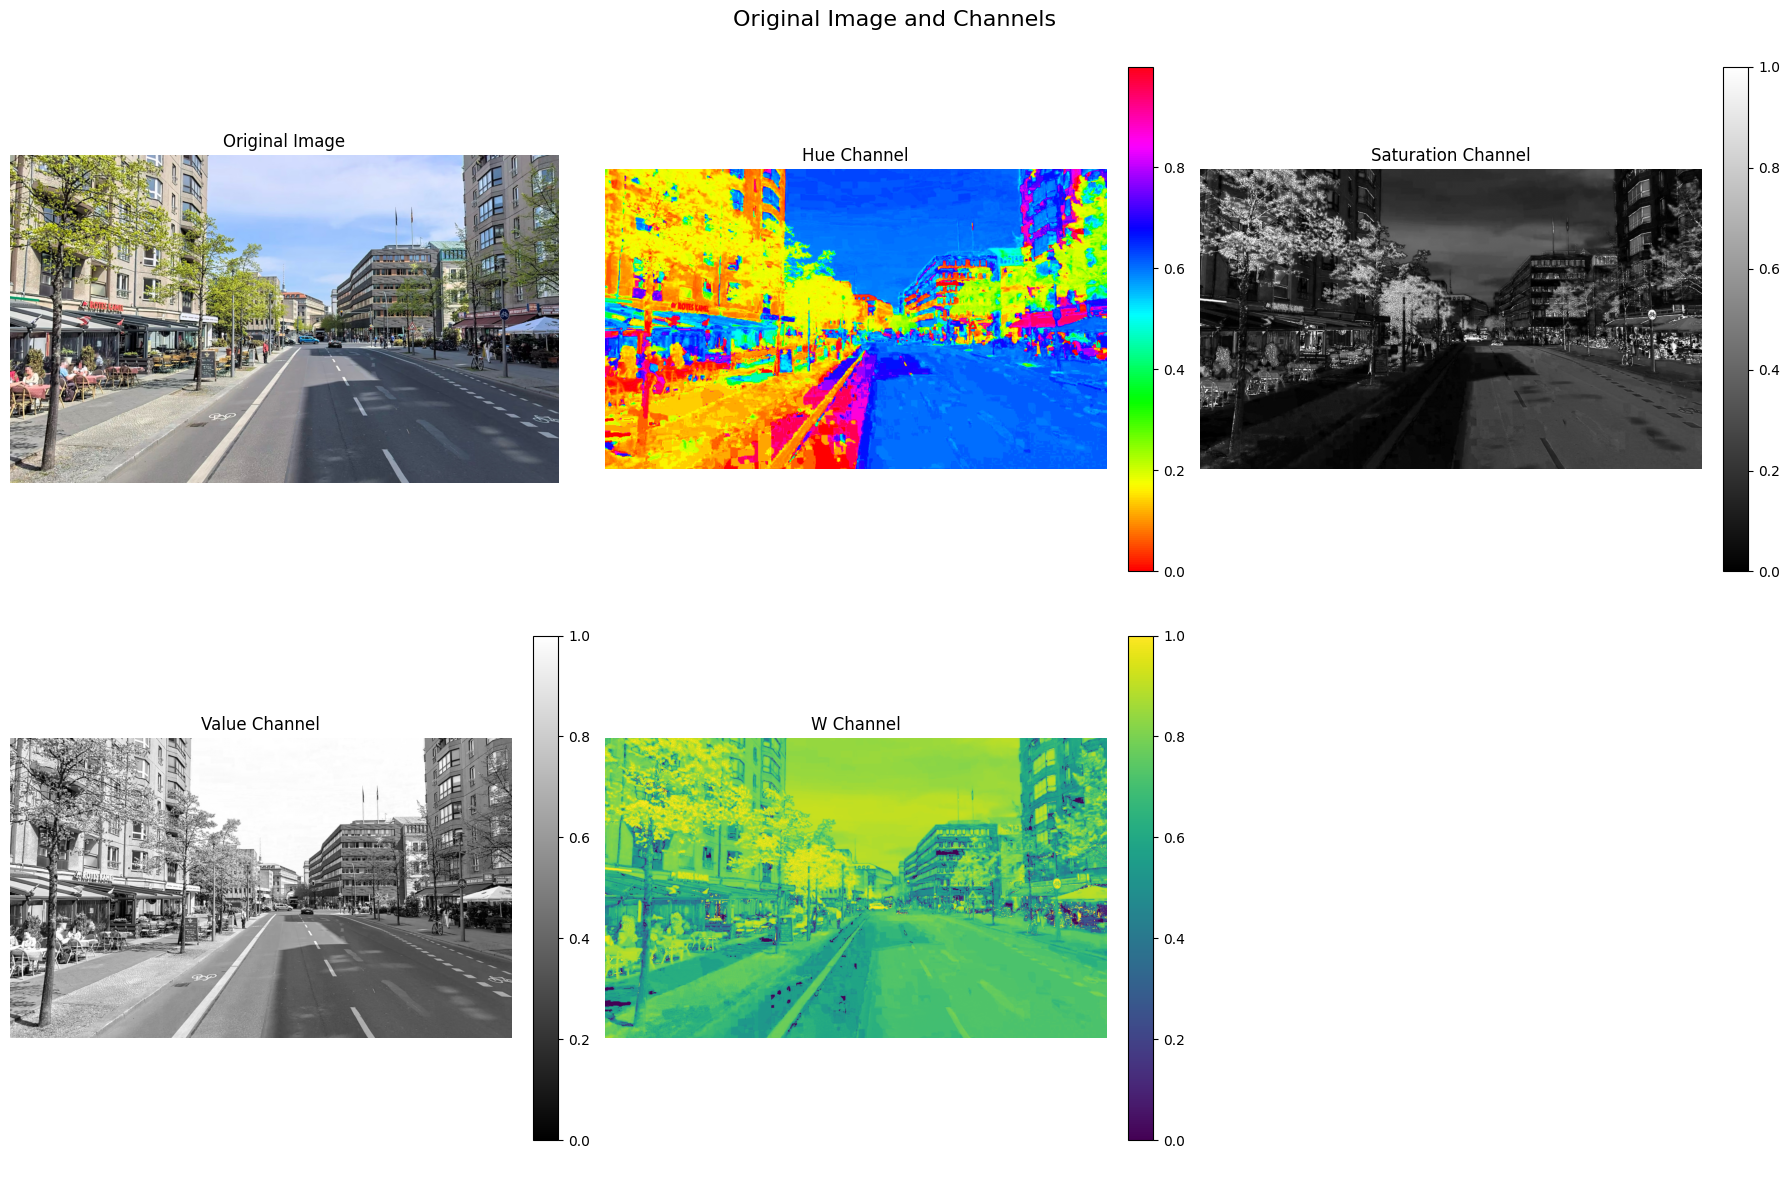

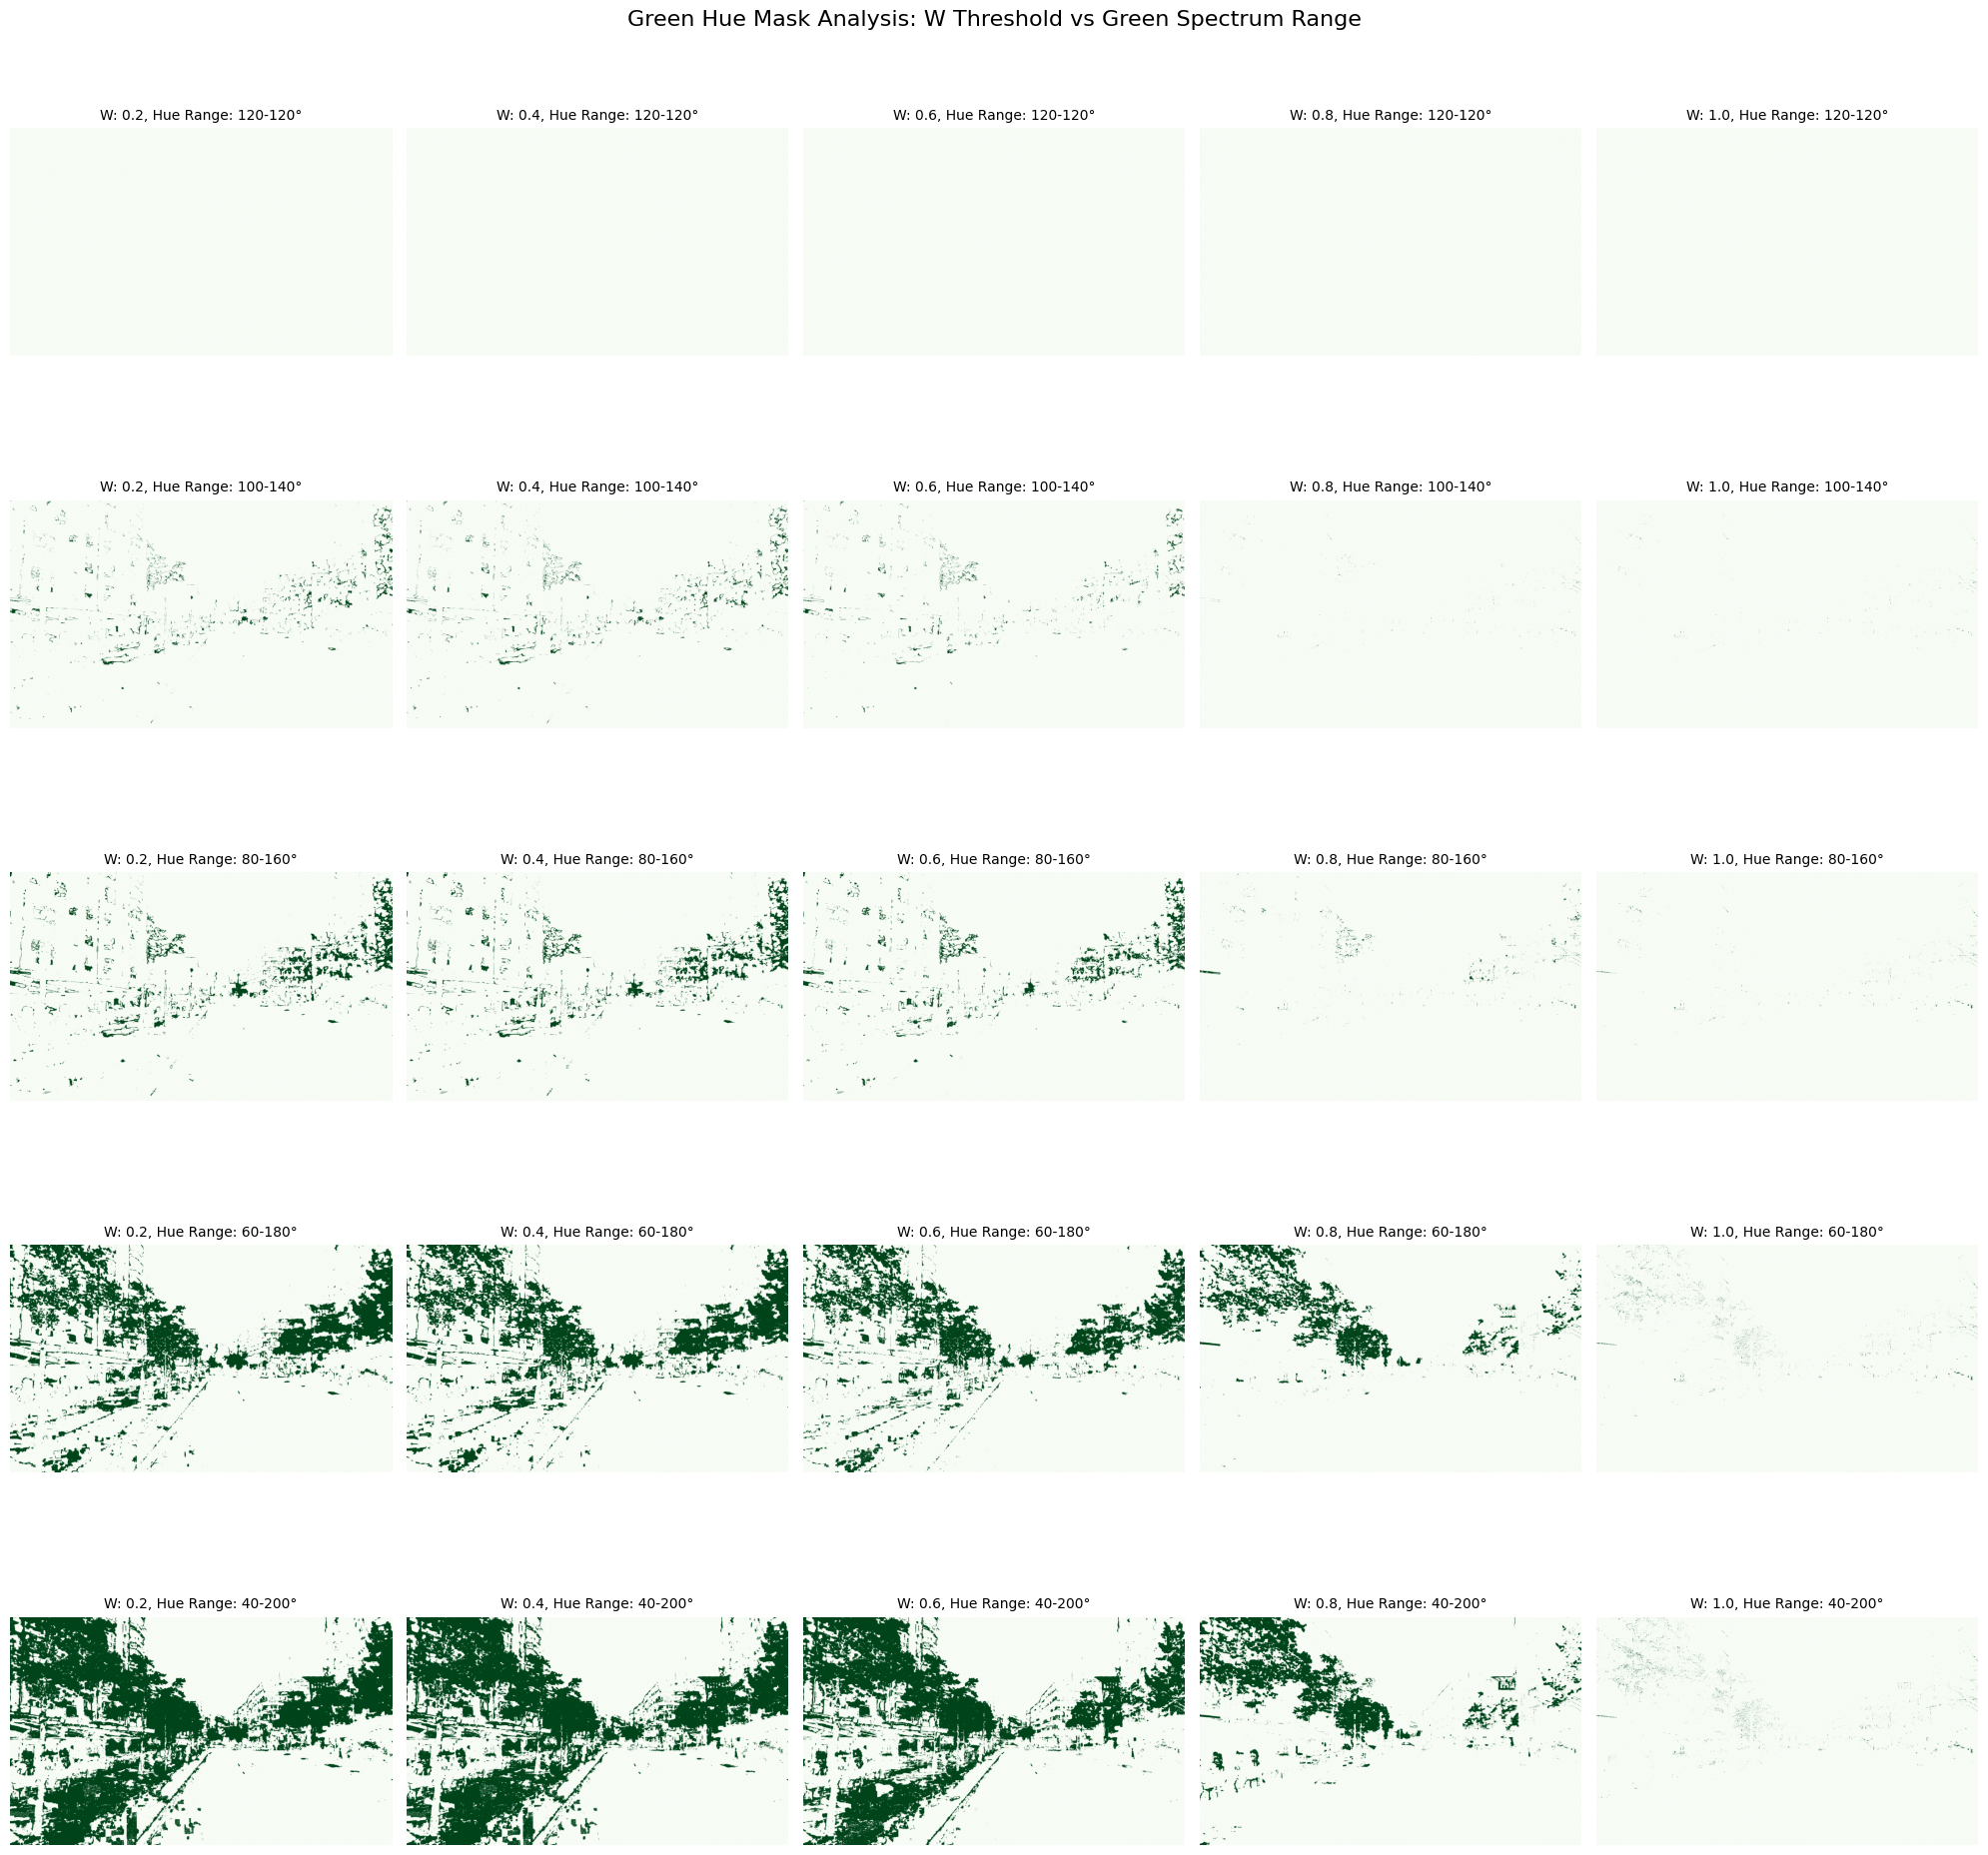


SUMMARY STATISTICS
W Threshold  Green Range     W Density    Green Density   Combined Density  
----------------------------------------------------------------------------------------------------
0.2          120-120°        0.9869       0.0000          0.0000            
0.2          100-140°        0.9869       0.0170          0.0169            
0.2          80-160°         0.9869       0.0494          0.0487            
0.2          60-180°         0.9869       0.1931          0.1919            
0.2          40-200°         0.9869       0.3577          0.3562            
0.4          120-120°        0.9645       0.0000          0.0000            
0.4          100-140°        0.9645       0.0170          0.0161            
0.4          80-160°         0.9645       0.0494          0.0465            
0.4          60-180°         0.9645       0.1931          0.1869            
0.4          40-200°         0.9645       0.3577          0.3480            
0.6          120-120°        0.8

In [19]:
def analyze_green_hue_variations(img_path, w_thresholds=[0.2, 0.4, 0.6, 0.8, 1.0], green_ranges=[(120, 120), (100, 140), (80, 160), (60, 180), (40, 200)]):
    """
    Analyze how different w thresholds and green spectrum ranges affect the green mask.
    
    Parameters:
        img_path: Path to the image file
        w_thresholds: List of w threshold values to test
        green_ranges: List of (min_hue, max_hue) tuples in degrees
    
    Returns:
        Dictionary containing all mask variations and their densities
    """
    # Load and process image
    img_bgr = cv2.imread(img_path)
    img = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    hsv = color.rgb2hsv(img)
    hue = hsv[:, :, 0]  # Hue in range [0, 1]
    W = compute_W(hsv)
    
    total_pixels = hue.size
    results = {}
    
    # Create all combinations
    for w_thresh in w_thresholds:
        for min_hue, max_hue in green_ranges:
            # Convert hue degrees to [0, 1] range
            min_hue_norm = min_hue / 360.0
            max_hue_norm = max_hue / 360.0
            
            # Create masks
            w_mask = W >= w_thresh
            green_mask = (hue >= min_hue_norm) & (hue < max_hue_norm)
            combined_mask = green_mask & w_mask
            
            # Calculate densities
            w_density = w_mask.sum() / total_pixels
            green_density = green_mask.sum() / total_pixels
            combined_density = combined_mask.sum() / total_pixels
            
            # Store results
            key = f"w{w_thresh}_g{min_hue}-{max_hue}"
            results[key] = {
                'w_threshold': w_thresh,
                'green_range': (min_hue, max_hue),
                'w_mask': w_mask,
                'green_mask': green_mask,
                'combined_mask': combined_mask,
                'w_density': w_density,
                'green_density': green_density,
                'combined_density': combined_density
            }
    
    return results, img, hsv, W

def display_original_image_and_channels(img, hsv, W):
    """
    Display the original image and all channels as a separate plot.
    """
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Original Image and Channels', fontsize=16)
    
    # Original image
    axes[0, 0].imshow(img)
    axes[0, 0].set_title('Original Image')
    axes[0, 0].axis('off')
    
    # Hue channel
    im1 = axes[0, 1].imshow(hsv[:, :, 0], cmap='hsv')
    axes[0, 1].set_title('Hue Channel')
    axes[0, 1].axis('off')
    plt.colorbar(im1, ax=axes[0, 1], fraction=0.046, pad=0.04)
    
    # Saturation channel
    im2 = axes[0, 2].imshow(hsv[:, :, 1], cmap='gray')
    axes[0, 2].set_title('Saturation Channel')
    axes[0, 2].axis('off')
    plt.colorbar(im2, ax=axes[0, 2], fraction=0.046, pad=0.04)
    
    # Value channel
    im3 = axes[1, 0].imshow(hsv[:, :, 2], cmap='gray')
    axes[1, 0].set_title('Value Channel')
    axes[1, 0].axis('off')
    plt.colorbar(im3, ax=axes[1, 0], fraction=0.046, pad=0.04)
    
    # W channel
    im4 = axes[1, 1].imshow(W, cmap='viridis')
    axes[1, 1].set_title('W Channel')
    axes[1, 1].axis('off')
    plt.colorbar(im4, ax=axes[1, 1], fraction=0.046, pad=0.04)
    
    # Clear the last subplot
    axes[1, 2].axis('off')
    
    plt.tight_layout()
    plt.show()

def create_5x5_grid_visualization(results, w_thresholds, green_ranges):
    """
    Create a 5x5 grid showing different mask variations.
    Columns: W thresholds [0.2, 0.4, 0.6, 0.8, 1.0]
    Rows: Green ranges [120-120, 100-140, 80-160, 60-180, 40-200]
    """
    fig, axes = plt.subplots(5, 5, figsize=(20, 20))
    fig.suptitle('Green Hue Mask Analysis: W Threshold vs Green Spectrum Range', fontsize=16)
    
    # Set row and column labels
    for i, (min_hue, max_hue) in enumerate(green_ranges):
        axes[i, 0].set_ylabel(f'Green Range\n{min_hue}-{max_hue}°', rotation=0, labelpad=50, ha='right')
    
    for j, w_thresh in enumerate(w_thresholds):
        axes[0, j].set_title(f'W Threshold\n{w_thresh}', pad=20)
    
    # Fill the grid
    for i, (min_hue, max_hue) in enumerate(green_ranges):
        for j, w_thresh in enumerate(w_thresholds):
            key = f"w{w_thresh}_g{min_hue}-{max_hue}"
            result = results[key]
            
            # Display the combined mask
            axes[i, j].imshow(result['combined_mask'], cmap='Greens')
            axes[i, j].set_title(f'W: {w_thresh}, Hue Range: {min_hue}-{max_hue}°', fontsize=10)
            axes[i, j].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\n" + "="*100)
    print("SUMMARY STATISTICS")
    print("="*100)
    print(f"{'W Threshold':<12} {'Green Range':<15} {'W Density':<12} {'Green Density':<15} {'Combined Density':<18}")
    print("-"*100)
    
    for w_thresh in w_thresholds:
        for min_hue, max_hue in green_ranges:
            key = f"w{w_thresh}_g{min_hue}-{max_hue}"
            result = results[key]
            print(f"{w_thresh:<12} {f'{min_hue}-{max_hue}°':<15} {result['w_density']:<12.4f} {result['green_density']:<15.4f} {result['combined_density']:<18.4f}")

# Test with one image
test_image_path = f"{folder_path}/HTHB02.jpg"
print(f"Analyzing image: {test_image_path}")

# Define the specific parameters
w_thresholds = [0.2, 0.4, 0.6, 0.8, 1.0]
green_ranges = [(120, 120), (100, 140), (80, 160), (60, 180), (40, 200)]

# Run the analysis
results, img, hsv, W = analyze_green_hue_variations(test_image_path, w_thresholds, green_ranges)

# Display the first plot: original image and channels
display_original_image_and_channels(img, hsv, W)

# Create the second plot: 5x5 grid visualization
create_5x5_grid_visualization(results, w_thresholds, green_ranges)


# Compute for all images

In [20]:
def detect_straight_edges(img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY).astype(np.float64) / 255.0
    total_pixels = gray.size

    edges = feature.canny(gray, sigma=1.0)
    smoothed = filters.gaussian(gray, sigma=1)
    Gx, Gy = np.gradient(smoothed)
    theta = np.mod(np.degrees(np.arctan2(Gy, Gx)), 360)
    bins = np.linspace(0, 360, 9)
    dir_bins = np.digitize(theta, bins) - 1

    straight_mask = np.zeros_like(edges, dtype=bool)
    for d in range(8):
        mask = edges & (dir_bins == d)
        if np.count_nonzero(mask) < 5:
            continue
        labels = measure.label(mask, connectivity=2)
        for region in measure.regionprops(labels):
            coords = region.coords
            if coords.shape[0] < 5:
                continue
            y, x = coords[:, 0], coords[:, 1]
            cov = np.cov(x, y)
            eigvals = np.linalg.svd(cov, compute_uv=False)
            if eigvals[0] > 104 * eigvals[1]:
                straight_mask[y, x] = True

    non_straight_mask = edges & ~straight_mask

    straight_density = straight_mask.sum() / total_pixels
    non_straight_density = non_straight_mask.sum() / total_pixels

    return straight_density, non_straight_density, straight_mask, non_straight_mask


def fractal_dimension_boxcount(bw):
    rows, cols = bw.shape
    max_box = min(rows, cols)
    sizes = 2 ** np.arange(int(np.floor(np.log2(max_box))), 0, -1)
    counts = []
    for size in sizes:
        count = 0
        for r in range(0, rows, size):
            for c in range(0, cols, size):
                sub = bw[r:r+size, c:c+size]
                if np.any(sub):
                    count += 1
        counts.append(count)
    log_counts = np.log(counts)
    log_sizes = np.log(1.0 / sizes)
    coeffs = np.polyfit(log_sizes, log_counts, 1)
    return coeffs[0]

Processing file HTHB02.jpg:   0%|          | 0/1 [00:00<?, ?file/s]

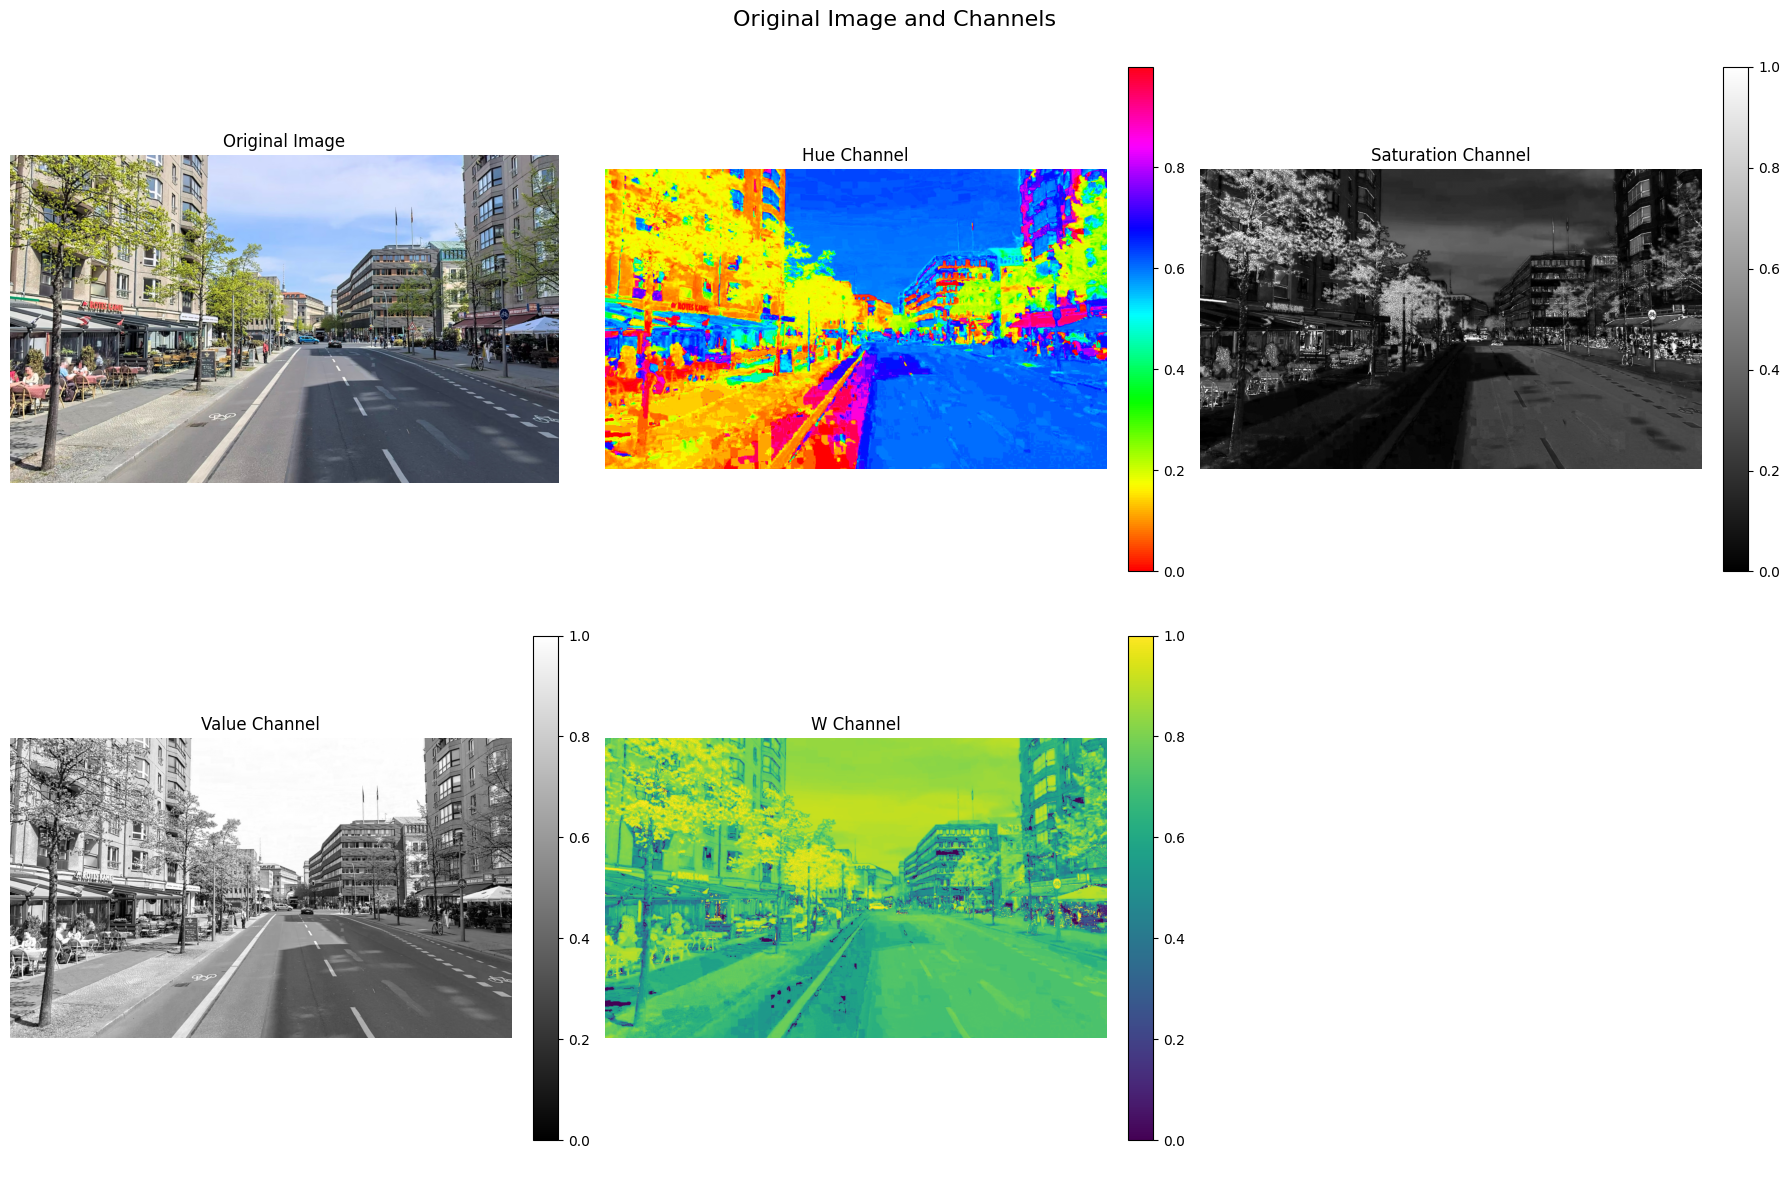

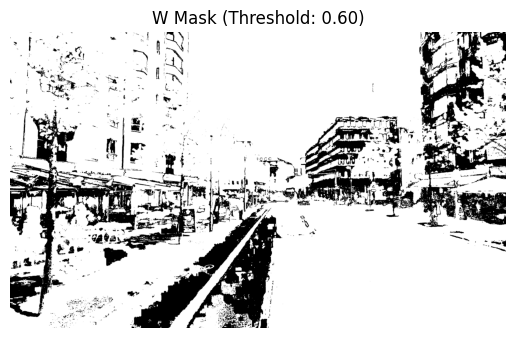

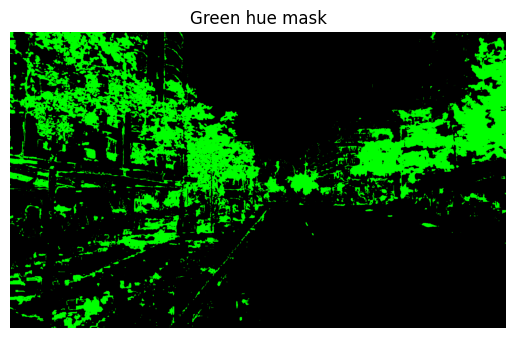

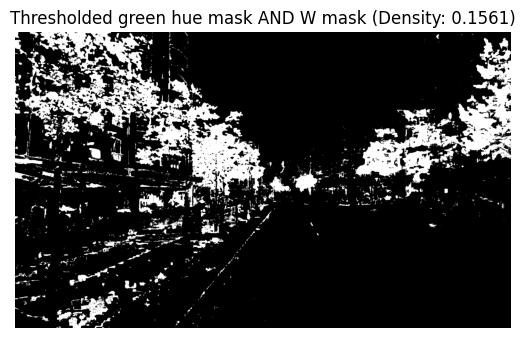

Processing file HTHB02.jpg: 100%|██████████| 1/1 [00:12<00:00, 12.98s/file]

{
    "ImageName": "HTHB02.jpg",
    "HSVHue": 0.4208,
    "Brightness": 135.3127,
    "sdBrightness": 62.9463,
    "Saturation": 0.2171,
    "sdSaturation": 0.1782,
    "StraightEdgeDensity": 0.0301,
    "NonStraightEdgeDensity": 0.094,
    "Entropy": 7.6856,
    "FractalD": 1.8748,
    "GreenMaskWThresholdedDensity": 0.1561
}
Results saved to results_20251031_180943.csv


In [21]:
W_threshold = 0.6
green_hue_range = (60, 180)

def process_image(file_path):
    file_name = os.path.basename(file_path)

    img_bgr = cv2.imread(file_path)
    img = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    
    hsv = color.rgb2hsv(img)
    hue = hsv[:, :, 0]
    
    hsv_hue = hue.mean()
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    brightness = gray.mean()
    sd_brightness = gray.std()
    S = hsv[:, :, 1]
    saturation = S.mean()
    sd_saturation = S.std()

    sed, nsed, _, _ = detect_straight_edges(img)

    entropy_val = measure.shannon_entropy(gray, base=2)
    _, bw = cv2.threshold(gray, 0, 1, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    fractal_d = fractal_dimension_boxcount(bw.astype(bool))

    result = {
        'ImageName': file_name,
        'HSVHue': hsv_hue,
        'Brightness': brightness,
        'sdBrightness': sd_brightness,
        'Saturation': saturation,
        'sdSaturation': sd_saturation,
        'StraightEdgeDensity': sed,
        'NonStraightEdgeDensity': nsed,
        'Entropy': entropy_val,
        'FractalD': fractal_d
    }



    total_count = hue.size    

    # W
    W = compute_W(hsv)

    display_original_image_and_channels(img, hsv, W)  

    W_mask = W >= W_threshold

    plt.figure()
    plt.imshow(W_mask, cmap='gray')
    plt.title(f"W Mask (Threshold: {W_threshold:.2f})")
    plt.axis('off')
    plt.show()


    # Create the green hue mask
    green_mask = (hue >= green_hue_range[0]/360) & (hue < green_hue_range[1]/360)
    
    visualization = np.zeros((*green_mask.shape, 3), dtype=np.uint8)
    visualization[green_mask] = [0, 255, 0]  # Green for green hue    

    plt.figure()
    plt.imshow(visualization)
    plt.title(f"Green hue mask")
    plt.axis('off')
    plt.show()
    

    # Thresholded green hue mask AND W mask
    combined_mask = green_mask & W_mask
    combined_density = combined_mask.sum() / total_count
    plt.figure()
    plt.imshow(combined_mask, cmap='gray')
    plt.title(f"Thresholded green hue mask AND W mask (Density: {combined_density:.4f})")
    plt.axis('off')
    plt.show()

    result['GreenMaskWThresholdedDensity'] = combined_density
    
    return result

do_for_each_jpeg_file_in_folder(folder_path, process_image)